## Key Takeaways

### For NNs using Images
- Convolutions are helpful
- SGD isn't as good as newer optimizers like Adam and NesterovAdam - https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f
- normalization is helpful (both of the features and the output) and helps prevent divergence
- batch normalization works well after the activation https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md
- need to go deeper as validation loss is brought in line with training loss


### Generally
- Never trust the data blindly


#### Link to models
https://drive.google.com/drive/folders/1IcfVLCy_btNzYmqzvKzyVPFQQkKrYVvZ?usp=sharing

## Setup

### Imports

In [1]:
%matplotlib inline
from pandas.io.parsers import read_csv
from sklearn.model_selection import train_test_split

import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Nadam, Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, Callback, History
from keras.applications.inception_v3  import InceptionV3
from keras.applications.vgg16 import VGG16

from tensorflow.python.client import device_lib

from augmentdata.CustImageDataGenerator import CustImageDataGenerator,CustNumpyArrayIterator

print(device_lib.list_local_devices()) # confirm using GPU

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15191720741719057585
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10459227909075539897
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10805749470390720517
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11286970368
locality {
  bus_id: 1
}
incarnation: 18342555859330319452
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


### Constants

In [2]:
TRAIN_DATA = '/data/data/training.csv'                # train dataset downloaded from Kaggle
TEST_DATA = '/data/data/test.csv'                     # test dataset downloaded from Kaggle
IMAGE_ROWS = 96
IMAGE_COLS = 96
INPUT_SHAPE = (IMAGE_ROWS, IMAGE_COLS, 1)
RETRAIN = False                                    # bool to load and use existing saved models
VERBOSE_TRAIN = False                              # bool to show/hide progress while training a model
NUM_KEYPOINTS = 30                                 # maximum no. of facial keypoints for any image


## EDA on train dataset

We begin by examining the train dataset of images (training.csv file), which is organised as (x,y) coodinates of each of the 15 facial features for a total of 30 keypoints. The 31st column contains 96x96 image pixel array data coded as raw grayscale values from 0 to 255. There are a total of about 7000 images in the train dataset. 

**Summary**: 
*For the EDA, the first pass was done over the whole dataset. From this, roughly 320 images were identified that had missing keypoints or peculiarities, needing further evaluation. In this second pass, we decided to prune the input train dataset to the models, by picking out images that were misfits, and would likely end up confusing the model, rather than helping it. This analysis and some interesting images we came across are illustrated below.*


In [3]:
# Setting up the data for EDA

df_train = pd.read_csv(TRAIN_DATA)
Y = np.array(df_train[df_train.columns.difference(['Image'])])
X = df_train['Image']
labels = list(df_train.columns.difference(['Image']))

img_vec_len = IMAGE_ROWS*IMAGE_COLS                             # images pixel grid size

imgArray = np.zeros((X.shape[0], img_vec_len), dtype=int)       # temporary array to save each image as numpy array

idx=0
for i in X.keys(): 
    imgArray[idx] = np.fromstring(X[i], dtype=int, sep=' ')
    idx += 1
X = np.reshape( imgArray, (X.shape[0], IMAGE_ROWS, IMAGE_COLS, 1) )
print("Total images in train dataset: ", X.shape[0])

Total images in train dataset:  7049


In [4]:
# Function to subplot a group of images, and label the ones with missing keypoints distinctly

def plot_images(images, points, type='actual', subplotting=False, gridRows=0, gridCols=0, 
                imageIndices=1, subtitles=True, title=None, labelsList=[] ):
    
    plt.figure(figsize=(4*gridCols, 4*gridCols))    
    img_nums = images.shape[0]
    points_nums = points.shape[0]
    
    if ( ( img_nums != points_nums) | ( img_nums != imageIndices.shape[0] ) ):
        raise ValueError("Mismatch in number of images and keypoints' rows passed to plot_images().")
    
    
    for thisImg in range(0, gridRows*gridCols ):
        
        if subplotting:
            plt.subplot(gridRows, gridCols, thisImg + 1)
            noKeypNums  = np.isnan(points[thisImg]).sum()
            
            if subtitles:
                if( noKeypNums == 0 ):                                                            # no missing keypoints (group1)
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='k')         # title in black
                
                elif( ( noKeypNums > 0) & (noKeypNums < 22 ) ):                                   # (1,21) missing keypoints
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='m')         # title in magenta
                
                elif( ( noKeypNums == 22 ) ):                                                     # 22 missing keypoints (group2)
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='b')         # title in blue
                
                else:                                                                             # > 22 missing keypoints
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='r')         # title in red
        
        plt.imshow(np.reshape(images[thisImg,:],(96,96)), cmap = 'gray')

        x = 0
        for idx in range(0, points[thisImg].shape[0]):
            label = labelsList[idx]
            if label[-1]=='x':
                x = points[thisImg, idx]
            else:
                if label in ['left_eye_center_y',
                             'left_eye_inner_corner_y', 
                             'left_eye_outer_corner_y', 
                             'left_eyebrow_inner_end_y', 
                             'left_eyebrow_outer_end_y',
                             'mouth_left_corner_y'
                            ]:
                    if(type=='actual'):
                        plt.plot(x, points[thisImg, idx], 'c<')
                    else:
                        plt.plot(x, points[thisImg, idx], 'c*')
                        
                elif label in ['right_eye_center_y',
                             'right_eye_inner_corner_y', 
                             'right_eye_outer_corner_y', 
                             'right_eyebrow_inner_end_y', 
                             'right_eyebrow_outer_end_y',
                              'mouth_right_corner_y']:
                    if(type=='actual'):
                        plt.plot(x, points[thisImg, idx], 'r>')
                    else:
                        plt.plot(x, points[thisImg, idx], 'r*')
                
                else:
                    if(type=='actual'):
                        plt.plot(x, points[thisImg, idx], 'mo')
                    else:
                        plt.plot(x, points[thisImg, idx], 'm*')
                    
        plt.axis('off')
    
    if (title != None):
        plt.suptitle(title)
    plt.show()

In [5]:
# Function to plot an array of image indices

idx_max = df_train.shape[0]                      # all images
grid_cols = 4                                    # grid columns size for a subplot of images
grid_rows = 4                                    # grid rows size for images subplot
subImgNum = grid_cols * grid_rows

def plot_img_group( thisGroup, dataset='train', denorm=False, thisLabels=labels, thisSubTitle=True, thisTitle=None ):

    if(dataset == 'train'):
        thisX = X
        thisY = Y
    elif(dataset == 'group1'):
        thisX = X1
        thisY = Y1
    elif(dataset == 'group2'):
        thisX = X2
        thisY = Y2     
    
    thisSubsetX = np.zeros( (subImgNum, IMAGE_ROWS, IMAGE_COLS, 1), dtype=float)
    thisSubsetY = np.zeros( (subImgNum, thisY.shape[1]), dtype=float)
    img_indices = np.zeros( (subImgNum, 1), dtype=int)

    img_sub = 0                                  # local iterator for images in subplot
    flushed = False
    for img in thisGroup:
        
        if( ( (img_sub + 1 )  % subImgNum ) != 0 ):
            thisSubsetX[img_sub,:] = thisX[img-1,:]
            if denorm:
                thisSubsetY[img_sub,:] = 48*thisY[img-1,:] + 48
            else:
                thisSubsetY[img_sub,:] = thisY[img-1,:]
            img_indices[img_sub] = img
            img_sub += 1
            flushed = False
            
        else:
            thisSubsetX[img_sub,:] = thisX[img-1,:]
            if denorm:
                thisSubsetY[img_sub,:] = 48*thisY[img-1,:] + 48
            else:
                thisSubsetY[img_sub,:] = thisY[img-1,:]
            img_indices[img_sub] = img
            
            # plot when all images for the subplot are accumulated
            plot_images(images=thisSubsetX, points=thisSubsetY, subplotting=True, 
                        gridRows=grid_rows, gridCols=grid_cols, imageIndices=img_indices, 
                        subtitles=thisSubTitle, title=thisTitle, labelsList=thisLabels )
            
            # reset subplot indexing pointer and subplot image/keypoints buckets
            img_sub = 0
            flushed = True
            thisSubsetX = np.zeros( (subImgNum, IMAGE_ROWS, IMAGE_COLS, 1), dtype=int)
            thisSubsetY = np.zeros( (subImgNum, Y.shape[1]), dtype=float)
    
    if not flushed:                              # for images leftover from partial subplot grid

        thisGridRows = ( (img_sub - 1) // grid_rows ) + 1
        if( thisGridRows > 1 ):
            thisGridCols = grid_cols
        else:
            thisGridCols = img_sub

        plot_images(images=thisSubsetX, points=thisSubsetY, subplotting=True, 
                    gridRows=thisGridRows, gridCols=thisGridCols, imageIndices=img_indices, 
                    subtitles=thisSubTitle, title=thisTitle, labelsList=thisLabels )


The images in the train dataset seem to be broadly split into two groups. The first group starts from the beginning of the dataset and (index 1, or row 1 in .csv) and continues till index 2284. Beyond that, the images have a maximum of 8 keypoints.

Below is a sample of images around this boundary - images with 30 keypoints or less and those with 8 keypoints or less. Also, there are some images with missing keypoints, with their titles highlighted in magenta or red colors.

In [6]:
# Final indices of images to be dropped from the dataset

IDX_BAD_IMAGES = np.array( [1621, 1862, 1748, 1878, 1927, 2200, 2431, 2584, 2647, 
                            2671, 2765, 4198, 1627, 1628, 1637, 1957, 4477, 1820, 
                            2064, 2089, 2091, 2109, 2195, 4264, 4491, 6490, 6493, 
                            6494, 1655, 2096, 2454, 3206, 3287, 5628, 5653, 6754, 
                            6755, 2321, 2322, 2414, 2428, 2462, 2574, 2584, 2663, 
                            2691, 2694, 2830, 2910, 2916, 3126, 3176, 3291, 3299, 
                            3361, 4061, 4483, 4484, 4494, 4766, 4809, 4837, 4880, 
                            4905, 5068, 5362, 5566, 5868, 6535, 6538, 6588, 6605, 
                            6659, 6724, 6733, 6753, 6758, 6766, 6907 ] )
#plot_img_group( IDX_BAD_IMAGES )

### Preparing the training data for models

In [7]:
# Function to clean up the train dataset, normalize it, drop bad images & labels, 
# and finally split the dataset into 2, for group1 and group2 modelling.

def loaderV2(test=False, seed=None, keeplabels=None):
    
    if seed:
        np.random.seed(seed)
    fileloc = TEST_DATA if test else TRAIN_DATA
    
    df = read_csv(fileloc)
    
    df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
    
    if keeplabels:
        df = df[list(keeplabels) + ['Image']]
        
    X = np.vstack(df['Image'])
    
    if not test:                                                  # process train dataset
        Y = df[df.columns.difference(['Image'])].values
        Y = Y.astype(np.float32)
        
        # remove rows having bad images or labels
        X = np.delete( X, (IDX_BAD_IMAGES - 1), axis=0 )
        Y = np.delete( Y, (IDX_BAD_IMAGES - 1), axis=0 )
        
        # normalize - by pixel across the whole dataset subtract mean and divide by stdev
        X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
        X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
        X = X.astype(np.float32)
    
        Y = (Y - 48) / 48                     # this helps, but tanh on output doesnt
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, Y = X[shuffle], Y[shuffle]
    
        X = X.reshape(-1, 96, 96, 1)
        
        # split X and Y into dataset for model1 (more than 8 keypoints) and model2 (less than 8 keypoints)
        X_model1 = np.zeros( (X.shape[0], 96,96,1), dtype=np.float32)
        X_model2 = np.zeros( (X.shape[0], 96,96,1), dtype=np.float32)
        Y_model1 = np.zeros( Y.shape, dtype=float)
        Y_model2 = np.zeros( Y.shape, dtype=float)
        tempIdx1 = 0
        tempIdx2 = 0
        
        for thisIdx in range(0, Y.shape[0]):
            numKeyps  = NUM_KEYPOINTS - np.isnan(Y[thisIdx]).sum()
            
            if( ( numKeyps > 8 ) ):
                X_model1[tempIdx1] = X[thisIdx,:,:]
                Y_model1[tempIdx1] = Y[thisIdx,:]
                tempIdx1 = tempIdx1 + 1
            else:
                X_model2[tempIdx2] = X[thisIdx,:,:]
                Y_model2[tempIdx2] = Y[thisIdx,:]
                tempIdx2 = tempIdx2 + 1
    
        # remove empty rows
        drop_idx1 = []
        drop_idx2 = []
        
        for idx in range(0, X.shape[0]):
            if( (np.all(Y_model1[idx] == 0)) | (np.isnan(Y_model1[idx]).sum() != 0) ):
                drop_idx1.append(idx)
            if( (np.all(Y_model2[idx] == 0)) | (np.isnan(Y_model2[idx]).sum() != 22) ):
                drop_idx2.append(idx)
        
        X_model1 = np.delete( X_model1, np.array(drop_idx1), axis=0 )
        Y_model1 = np.delete( Y_model1, np.array(drop_idx1), axis=0 )
        X_model2 = np.delete( X_model2, np.array(drop_idx2), axis=0 )
        Y_model2 = np.delete( Y_model2, np.array(drop_idx2), axis=0 )            
        
        # remove empty columns, setup lists of labels
        labels = df.columns.difference(['Image'])
        labels1 = labels
        labels2 = []
        drop_idx3 = []
        for idx in range(0, Y.shape[1]):
            if( (np.all(Y_model2[:,idx] == 0)) | (np.isnan(Y_model2[:,idx]).sum() != 0) ):
                drop_idx3.append(idx)
            else:
                labels2.append(labels[idx])
        Y_model2 = np.delete( Y_model2, np.array(drop_idx3), axis=1 ) 
        
        # return the original dataset and the group splits
        return X_model1, Y_model1, labels1, X_model2, Y_model2, labels2, X, Y, labels
    
    else:                                             # for test dataset
        Y = None
        
        # normalize - by pixel across the whole dataset subtract mean and divide by stdev
        X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
        X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
        X = X.reshape(-1, 96, 96, 1)
        labels = df.columns.difference(['Image'])
        
        return X, Y, labels
    

In [8]:
X1, Y1, labels1,   X2, Y2, labels2,   X, Y, labels = loaderV2(seed=42)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1,
                                                        test_size=0.2,
                                                        random_state=42)

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2,
                                                        test_size=0.2,
                                                        random_state=42)

data1 = [X1_train, X1_test, Y1_train, Y1_test]
data2 = [X2_train, X2_test, Y2_train, Y2_test]


In [9]:
print("Group1 data Y1 shape: ", Y1.shape, ", X1 shape: ", X1.shape)
print("Group2 data Y2 shape: ", Y2.shape, ", X2 shape: ", X2.shape)


Group1 data Y1 shape:  (2137, 30) , X1 shape:  (2137, 96, 96, 1)
Group2 data Y2 shape:  (4697, 8) , X2 shape:  (4697, 96, 96, 1)


### Plot some sample images

### Model Fitting Function

In [10]:
def fit_model(model, data, modelname,
              generator=None,retrain=RETRAIN,
              epochs=1000, patience=1000, optimizer='nadam'):
    if retrain or not os.path.exists('/data/saved-models/' + modelname + '.h5'):
        X_train = data[0]
        y_train = data[2]
        if len(data) == 4:
            valid_dat = (data[1], data[3])
        else:
            valid_dat = None

        model.compile(loss='mse', optimizer=optimizer)
        
        if valid_dat:
            earlystop = EarlyStopping(monitor='val_loss',
                                     patience=patience,
                                     verbose=1,
                                     mode="auto")
            callbacks = [earlystop]
        else:
            callbacks = None
        
        if generator:
            history = model.fit_generator(generator,
                        epochs=epochs,
                        steps_per_epoch=data[0].shape[0]//32,
                        callbacks=callbacks,
                        validation_data=valid_dat
             )
        else:
            history = model.fit(X_train, y_train,
                                epochs=epochs,
                                batch_size=32,
                                callbacks=callbacks,
                                validation_data=valid_dat,
                                verbose=VERBOSE_TRAIN
                     )
        model.save('/data/saved-models/'+ modelname + '.h5')
        with open('/data/saved-models/histories/'+modelname+'_hist',
                  'wb') as file_pi:
            pickle.dump(history.history, file_pi)
        history = history.history
    else:
        model = load_model('/data/saved-models/'+modelname+'.h5')
        history = pickle.load(open( "/data/saved-models/histories/" + modelname + '_hist',
                                   "rb" ))
        
    return history, model

### Helper function to plot the loss

In [11]:
def plot_loss(hists, names):
    colordict = {
        0 : 'b',
        1 : 'g',
        2 : 'r',
        3 : 'c',
        4 : 'm'
    }
    
    for i, hist in enumerate(hists):
        plt.plot([np.sqrt(x) * 48 for x in hist['loss']],
                 color=colordict[i],
                 label="train " + names[i])
        plt.plot([np.sqrt(x) * 48 for x in hist['val_loss']],
                 color=colordict[i],
                 linestyle=':',
                 label="valid " + names[i])
        plt.grid()
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("RMSE")
        plt.yscale("log")
    plt.show()

<h3>CNN_added layers model: </h3>

In [12]:
datagen = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X1_train,Y1_train,whichlabels=list(labels1), batch_size=32)

In [14]:
g1_model3_nadam = Sequential()
g1_model3_nadam.add(Conv2D(32,
                 (6, 6),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model3_nadam.add(BatchNormalization())
g1_model3_nadam.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_nadam.add(Conv2D(filters=64,
                 kernel_size=(5, 5),
                 activation='relu'))
g1_model3_nadam.add(BatchNormalization())
g1_model3_nadam.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_nadam.add(Conv2D(filters=256,
                 kernel_size=(4, 4),
                 activation='relu'))
g1_model3_nadam.add(BatchNormalization())
g1_model3_nadam.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_nadam.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 activation='relu'))
g1_model3_nadam.add(BatchNormalization())
g1_model3_nadam.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_nadam.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model3_nadam.add(BatchNormalization())
g1_model3_nadam.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_nadam.add(Flatten())
g1_model3_nadam.add(Dense(500, activation = "relu"))
g1_model3_nadam.add(BatchNormalization())
g1_model3_nadam.add(Dense(500, activation = "relu"))
g1_model3_nadam.add(BatchNormalization())
g1_model3_nadam.add(Dropout(.3))
g1_model3_nadam.add(Dense(30))
print(g1_model3_nadam.summary())
g1_CNN_aug_addedLayers_hist_nadam, g1_model3_new_nadam = fit_model(g1_model3_nadam, data1,'g1_CNN_aug_addedLayers',
                                                       datagen, patience=1000, retrain = True, optimizer='nadam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 91, 91, 32)        1184      
_________________________________________________________________
batch_normalization_8 (Batch (None, 91, 91, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 41, 41, 64)        51264     
_________________________________________________________________
batch_normalization_9 (Batch (None, 41, 41, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 17, 17, 256)       262400    
__________

53/53 [==============================] - 4s 70ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 50/1000
53/53 [==============================] - 4s 69ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 51/1000
53/53 [==============================] - 4s 69ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 52/1000
53/53 [==============================] - 4s 69ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 53/1000
53/53 [==============================] - 4s 69ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 54/1000
53/53 [==============================] - 4s 68ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 55/1000
53/53 [==============================] - 4s 68ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 56/1000
53/53 [==============================] - 4s 68ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 57/1000
53/53 [==============================] - 4s 68ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 58/1000
53/53 [==============================] - 4s 68ms/step - loss: 0.0037 - val_loss: 0

53/53 [==============================] - 4s 70ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 130/1000
53/53 [==============================] - 4s 69ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 131/1000
53/53 [==============================] - 4s 70ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 132/1000
53/53 [==============================] - 4s 69ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 133/1000
53/53 [==============================] - 4s 69ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 134/1000
53/53 [==============================] - 4s 69ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 135/1000
53/53 [==============================] - 4s 70ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 136/1000
53/53 [==============================] - 4s 70ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 137/1000
53/53 [==============================] - 4s 69ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 138/1000
53/53 [==============================] - 4s 70ms/step - loss: 0.0015 - va

53/53 [==============================] - 4s 68ms/step - loss: 9.9942e-04 - val_loss: 8.2720e-04
Epoch 206/1000
53/53 [==============================] - 4s 69ms/step - loss: 0.0010 - val_loss: 7.0351e-04
Epoch 207/1000
53/53 [==============================] - 4s 69ms/step - loss: 9.3854e-04 - val_loss: 7.4242e-04
Epoch 208/1000
53/53 [==============================] - 4s 67ms/step - loss: 9.6038e-04 - val_loss: 7.8034e-04
Epoch 209/1000
53/53 [==============================] - 4s 70ms/step - loss: 9.7075e-04 - val_loss: 7.1487e-04
Epoch 210/1000
53/53 [==============================] - 4s 70ms/step - loss: 0.0010 - val_loss: 6.8220e-04
Epoch 211/1000
53/53 [==============================] - 4s 69ms/step - loss: 9.9803e-04 - val_loss: 7.4608e-04
Epoch 212/1000
53/53 [==============================] - 4s 69ms/step - loss: 0.0010 - val_loss: 6.9395e-04
Epoch 213/1000
53/53 [==============================] - 4s 69ms/step - loss: 0.0010 - val_loss: 6.9529e-04
Epoch 214/1000
53/53 [==========

53/53 [==============================] - 4s 68ms/step - loss: 9.1334e-04 - val_loss: 6.6712e-04
Epoch 280/1000
53/53 [==============================] - 4s 69ms/step - loss: 9.3862e-04 - val_loss: 7.9076e-04
Epoch 281/1000
53/53 [==============================] - 4s 69ms/step - loss: 9.2715e-04 - val_loss: 6.6025e-04
Epoch 282/1000
53/53 [==============================] - 4s 70ms/step - loss: 9.1626e-04 - val_loss: 7.2312e-04
Epoch 283/1000
53/53 [==============================] - 4s 70ms/step - loss: 8.8457e-04 - val_loss: 6.8801e-04
Epoch 284/1000
53/53 [==============================] - 4s 70ms/step - loss: 8.8592e-04 - val_loss: 6.4118e-04
Epoch 285/1000
53/53 [==============================] - 4s 69ms/step - loss: 9.8713e-04 - val_loss: 7.0745e-04
Epoch 286/1000
53/53 [==============================] - 4s 69ms/step - loss: 8.9896e-04 - val_loss: 6.6512e-04
Epoch 287/1000
53/53 [==============================] - 4s 69ms/step - loss: 8.9542e-04 - val_loss: 6.9663e-04
Epoch 288/1000
5

Epoch 353/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.9515e-04 - val_loss: 5.6284e-04
Epoch 354/1000
53/53 [==============================] - 4s 69ms/step - loss: 8.4417e-04 - val_loss: 6.8463e-04
Epoch 355/1000
53/53 [==============================] - 4s 70ms/step - loss: 9.0200e-04 - val_loss: 7.0177e-04
Epoch 356/1000
53/53 [==============================] - 4s 69ms/step - loss: 8.4124e-04 - val_loss: 8.0272e-04
Epoch 357/1000
53/53 [==============================] - 4s 69ms/step - loss: 8.4219e-04 - val_loss: 6.1590e-04
Epoch 358/1000
53/53 [==============================] - 4s 70ms/step - loss: 8.3580e-04 - val_loss: 6.0615e-04
Epoch 359/1000
53/53 [==============================] - 4s 69ms/step - loss: 8.4573e-04 - val_loss: 5.9761e-04
Epoch 360/1000
53/53 [==============================] - 4s 70ms/step - loss: 8.0176e-04 - val_loss: 6.5818e-04
Epoch 361/1000
53/53 [==============================] - 4s 68ms/step - loss: 8.5826e-04 - val_loss: 6.9396e-04
E

Epoch 427/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.8035e-04 - val_loss: 6.3196e-04
Epoch 428/1000
53/53 [==============================] - 4s 70ms/step - loss: 8.4838e-04 - val_loss: 7.2292e-04
Epoch 429/1000
53/53 [==============================] - 4s 69ms/step - loss: 8.0907e-04 - val_loss: 7.1472e-04
Epoch 430/1000
53/53 [==============================] - 4s 69ms/step - loss: 8.0457e-04 - val_loss: 6.0322e-04
Epoch 431/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.7524e-04 - val_loss: 6.4371e-04
Epoch 432/1000
53/53 [==============================] - 4s 68ms/step - loss: 8.2891e-04 - val_loss: 5.9892e-04
Epoch 433/1000
53/53 [==============================] - 4s 68ms/step - loss: 7.2489e-04 - val_loss: 6.2086e-04
Epoch 434/1000
53/53 [==============================] - 4s 68ms/step - loss: 7.7529e-04 - val_loss: 7.1165e-04
Epoch 435/1000
53/53 [==============================] - 4s 68ms/step - loss: 7.3376e-04 - val_loss: 6.4550e-04
E

Epoch 501/1000
53/53 [==============================] - 4s 69ms/step - loss: 8.2728e-04 - val_loss: 6.3790e-04
Epoch 502/1000
53/53 [==============================] - 4s 70ms/step - loss: 7.6106e-04 - val_loss: 5.6911e-04
Epoch 503/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.2213e-04 - val_loss: 5.5979e-04
Epoch 504/1000
53/53 [==============================] - 4s 70ms/step - loss: 7.4714e-04 - val_loss: 5.2264e-04
Epoch 505/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.7615e-04 - val_loss: 5.6277e-04
Epoch 506/1000
53/53 [==============================] - 4s 70ms/step - loss: 7.6919e-04 - val_loss: 6.4569e-04
Epoch 507/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.5738e-04 - val_loss: 6.1442e-04
Epoch 508/1000
53/53 [==============================] - 4s 70ms/step - loss: 7.0291e-04 - val_loss: 6.7914e-04
Epoch 509/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.5598e-04 - val_loss: 5.7741e-04
E

Epoch 575/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.9415e-04 - val_loss: 6.3891e-04
Epoch 576/1000
53/53 [==============================] - 4s 70ms/step - loss: 7.7524e-04 - val_loss: 6.2400e-04
Epoch 577/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.0765e-04 - val_loss: 5.8242e-04
Epoch 578/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.1136e-04 - val_loss: 5.6745e-04
Epoch 579/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.1158e-04 - val_loss: 6.8549e-04
Epoch 580/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.9701e-04 - val_loss: 5.3874e-04
Epoch 581/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.5565e-04 - val_loss: 5.9956e-04
Epoch 582/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.8181e-04 - val_loss: 7.2961e-04
Epoch 583/1000
53/53 [==============================] - 4s 68ms/step - loss: 6.8064e-04 - val_loss: 5.9395e-04
E

Epoch 649/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.5929e-04 - val_loss: 5.6380e-04
Epoch 650/1000
53/53 [==============================] - 4s 71ms/step - loss: 6.9077e-04 - val_loss: 5.5227e-04
Epoch 651/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.5503e-04 - val_loss: 6.3467e-04
Epoch 652/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.7530e-04 - val_loss: 5.7216e-04
Epoch 653/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.1551e-04 - val_loss: 5.8869e-04
Epoch 654/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.7176e-04 - val_loss: 6.0169e-04
Epoch 655/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.9762e-04 - val_loss: 7.3981e-04
Epoch 656/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.8732e-04 - val_loss: 6.2163e-04
Epoch 657/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.2046e-04 - val_loss: 5.3046e-04
E

Epoch 723/1000
53/53 [==============================] - 4s 70ms/step - loss: 7.1799e-04 - val_loss: 5.7274e-04
Epoch 724/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.5900e-04 - val_loss: 5.2722e-04
Epoch 725/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.5604e-04 - val_loss: 6.8338e-04
Epoch 726/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.3498e-04 - val_loss: 5.6630e-04
Epoch 727/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.1523e-04 - val_loss: 5.5298e-04
Epoch 728/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.6049e-04 - val_loss: 7.0965e-04
Epoch 729/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.8021e-04 - val_loss: 5.7830e-04
Epoch 730/1000
53/53 [==============================] - 4s 70ms/step - loss: 7.5394e-04 - val_loss: 5.4651e-04
Epoch 731/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.3542e-04 - val_loss: 6.0984e-04
E

Epoch 797/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.8968e-04 - val_loss: 5.2607e-04
Epoch 798/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.3890e-04 - val_loss: 6.2008e-04
Epoch 799/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.8375e-04 - val_loss: 5.3089e-04
Epoch 800/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.5537e-04 - val_loss: 5.5355e-04
Epoch 801/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.4707e-04 - val_loss: 5.5668e-04
Epoch 802/1000
53/53 [==============================] - 4s 70ms/step - loss: 7.1708e-04 - val_loss: 5.4637e-04
Epoch 803/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.5995e-04 - val_loss: 5.9349e-04
Epoch 804/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.5417e-04 - val_loss: 5.5546e-04
Epoch 805/1000
53/53 [==============================] - 4s 70ms/step - loss: 7.4164e-04 - val_loss: 6.1314e-04
E

Epoch 871/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.0178e-04 - val_loss: 5.6776e-04
Epoch 872/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.1743e-04 - val_loss: 5.4750e-04
Epoch 873/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.6838e-04 - val_loss: 5.2867e-04
Epoch 874/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.2933e-04 - val_loss: 5.4441e-04
Epoch 875/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.4243e-04 - val_loss: 6.4064e-04
Epoch 876/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.3688e-04 - val_loss: 6.7300e-04
Epoch 877/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.2034e-04 - val_loss: 5.3032e-04
Epoch 878/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.3500e-04 - val_loss: 6.7772e-04
Epoch 879/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.9126e-04 - val_loss: 5.6883e-04
E

Epoch 945/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.3105e-04 - val_loss: 5.7598e-04
Epoch 946/1000
53/53 [==============================] - 4s 70ms/step - loss: 7.1805e-04 - val_loss: 6.6722e-04
Epoch 947/1000
53/53 [==============================] - 4s 70ms/step - loss: 7.1785e-04 - val_loss: 5.5684e-04
Epoch 948/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.1171e-04 - val_loss: 5.4408e-04
Epoch 949/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.5750e-04 - val_loss: 5.4446e-04
Epoch 950/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.6913e-04 - val_loss: 5.3046e-04
Epoch 951/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.6489e-04 - val_loss: 6.3671e-04
Epoch 952/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.7739e-04 - val_loss: 5.7133e-04
Epoch 953/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.5143e-04 - val_loss: 5.6990e-04
E

In [16]:
g1_model3_adam = Sequential()
g1_model3_adam.add(Conv2D(32,
                 (6, 6),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model3_adam.add(BatchNormalization())
g1_model3_adam.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_adam.add(Conv2D(filters=64,
                 kernel_size=(5, 5),
                 activation='relu'))
g1_model3_adam.add(BatchNormalization())
g1_model3_adam.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_adam.add(Conv2D(filters=256,
                 kernel_size=(4, 4),
                 activation='relu'))
g1_model3_adam.add(BatchNormalization())
g1_model3_adam.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_adam.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 activation='relu'))
g1_model3_adam.add(BatchNormalization())
g1_model3_adam.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_adam.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model3_adam.add(BatchNormalization())
g1_model3_adam.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_adam.add(Flatten())
g1_model3_adam.add(Dense(500, activation = "relu"))
g1_model3_adam.add(BatchNormalization())
g1_model3_adam.add(Dense(500, activation = "relu"))
g1_model3_adam.add(BatchNormalization())
g1_model3_adam.add(Dropout(.3))
g1_model3_adam.add(Dense(30))
print(g1_model3_adam.summary())
g1_CNN_aug_addedLayers_hist_adam, g1_model3_new_adam = fit_model(g1_model3_adam, data1,'g1_CNN_aug_addedLayers_adam',
                                                       datagen, patience=1000, retrain = True, optimizer= 'adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 91, 91, 32)        1184      
_________________________________________________________________
batch_normalization_22 (Batc (None, 91, 91, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 41, 41, 64)        51264     
_________________________________________________________________
batch_normalization_23 (Batc (None, 41, 41, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 17, 17, 256)       262400    
__________

53/53 [==============================] - 4s 67ms/step - loss: 0.0076 - val_loss: 0.0043
Epoch 50/1000
53/53 [==============================] - 4s 67ms/step - loss: 0.0079 - val_loss: 0.0038
Epoch 51/1000
53/53 [==============================] - 3s 66ms/step - loss: 0.0075 - val_loss: 0.0042
Epoch 52/1000
53/53 [==============================] - 4s 67ms/step - loss: 0.0071 - val_loss: 0.0041
Epoch 53/1000
53/53 [==============================] - 4s 67ms/step - loss: 0.0070 - val_loss: 0.0039
Epoch 54/1000
53/53 [==============================] - 3s 66ms/step - loss: 0.0068 - val_loss: 0.0041
Epoch 55/1000
53/53 [==============================] - 3s 66ms/step - loss: 0.0064 - val_loss: 0.0037
Epoch 56/1000
53/53 [==============================] - 4s 67ms/step - loss: 0.0059 - val_loss: 0.0037
Epoch 57/1000
53/53 [==============================] - 4s 67ms/step - loss: 0.0057 - val_loss: 0.0032
Epoch 58/1000
53/53 [==============================] - 4s 66ms/step - loss: 0.0056 - val_loss: 0

53/53 [==============================] - 4s 66ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 130/1000
53/53 [==============================] - 3s 66ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 131/1000
53/53 [==============================] - 4s 68ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 132/1000
53/53 [==============================] - 4s 66ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 133/1000
53/53 [==============================] - 3s 66ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 134/1000
53/53 [==============================] - 4s 68ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 135/1000
53/53 [==============================] - 4s 66ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 136/1000
53/53 [==============================] - 4s 66ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 137/1000
53/53 [==============================] - 3s 65ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 138/1000
53/53 [==============================] - 4s 68ms/step - loss: 0.0026 - va

53/53 [==============================] - 4s 66ms/step - loss: 0.0011 - val_loss: 7.6999e-04
Epoch 208/1000
53/53 [==============================] - 4s 67ms/step - loss: 0.0011 - val_loss: 7.9952e-04
Epoch 209/1000
53/53 [==============================] - 4s 67ms/step - loss: 0.0011 - val_loss: 7.1226e-04
Epoch 210/1000
53/53 [==============================] - 4s 67ms/step - loss: 0.0011 - val_loss: 7.5695e-04
Epoch 211/1000
53/53 [==============================] - 4s 67ms/step - loss: 0.0011 - val_loss: 7.5005e-04
Epoch 212/1000
53/53 [==============================] - 4s 67ms/step - loss: 0.0010 - val_loss: 7.5220e-04
Epoch 213/1000
53/53 [==============================] - 4s 67ms/step - loss: 0.0011 - val_loss: 7.9378e-04
Epoch 214/1000
53/53 [==============================] - 4s 68ms/step - loss: 0.0010 - val_loss: 7.9632e-04
Epoch 215/1000
53/53 [==============================] - 4s 67ms/step - loss: 0.0010 - val_loss: 6.8992e-04
Epoch 216/1000
53/53 [==============================

53/53 [==============================] - 4s 67ms/step - loss: 9.0854e-04 - val_loss: 7.0438e-04
Epoch 282/1000
53/53 [==============================] - 4s 68ms/step - loss: 9.0143e-04 - val_loss: 8.1385e-04
Epoch 283/1000
53/53 [==============================] - 4s 68ms/step - loss: 9.0646e-04 - val_loss: 6.7430e-04
Epoch 284/1000
53/53 [==============================] - 4s 66ms/step - loss: 8.6178e-04 - val_loss: 6.7714e-04
Epoch 285/1000
53/53 [==============================] - 4s 68ms/step - loss: 9.2725e-04 - val_loss: 6.4790e-04
Epoch 286/1000
53/53 [==============================] - 4s 68ms/step - loss: 8.6578e-04 - val_loss: 6.5247e-04
Epoch 287/1000
53/53 [==============================] - 4s 68ms/step - loss: 8.2809e-04 - val_loss: 7.4068e-04
Epoch 288/1000
53/53 [==============================] - 4s 68ms/step - loss: 8.2735e-04 - val_loss: 6.3779e-04
Epoch 289/1000
53/53 [==============================] - 4s 68ms/step - loss: 8.7733e-04 - val_loss: 6.2306e-04
Epoch 290/1000
5

Epoch 355/1000
53/53 [==============================] - 4s 68ms/step - loss: 8.2857e-04 - val_loss: 6.5056e-04
Epoch 356/1000
53/53 [==============================] - 4s 68ms/step - loss: 8.7687e-04 - val_loss: 6.4481e-04
Epoch 357/1000
53/53 [==============================] - 4s 66ms/step - loss: 7.8288e-04 - val_loss: 6.5756e-04
Epoch 358/1000
53/53 [==============================] - 4s 68ms/step - loss: 8.0669e-04 - val_loss: 5.7686e-04
Epoch 359/1000
53/53 [==============================] - 4s 68ms/step - loss: 7.7804e-04 - val_loss: 6.3404e-04
Epoch 360/1000
53/53 [==============================] - 4s 67ms/step - loss: 7.8383e-04 - val_loss: 5.9724e-04
Epoch 361/1000
53/53 [==============================] - 4s 68ms/step - loss: 7.5383e-04 - val_loss: 5.8364e-04
Epoch 362/1000
53/53 [==============================] - 4s 68ms/step - loss: 7.7849e-04 - val_loss: 6.4808e-04
Epoch 363/1000
53/53 [==============================] - 4s 66ms/step - loss: 7.8306e-04 - val_loss: 5.8615e-04
E

Epoch 429/1000
53/53 [==============================] - 4s 68ms/step - loss: 7.5414e-04 - val_loss: 5.4296e-04
Epoch 430/1000
53/53 [==============================] - 4s 68ms/step - loss: 7.6437e-04 - val_loss: 5.5038e-04
Epoch 431/1000
53/53 [==============================] - 4s 68ms/step - loss: 7.0688e-04 - val_loss: 5.3613e-04
Epoch 432/1000
53/53 [==============================] - 4s 67ms/step - loss: 7.1877e-04 - val_loss: 6.2196e-04
Epoch 433/1000
53/53 [==============================] - 4s 67ms/step - loss: 7.1564e-04 - val_loss: 5.9640e-04
Epoch 434/1000
53/53 [==============================] - 4s 67ms/step - loss: 7.5197e-04 - val_loss: 5.9132e-04
Epoch 435/1000
53/53 [==============================] - 4s 67ms/step - loss: 7.8108e-04 - val_loss: 5.6287e-04
Epoch 436/1000
53/53 [==============================] - 4s 67ms/step - loss: 7.2736e-04 - val_loss: 5.7952e-04
Epoch 437/1000
53/53 [==============================] - 4s 67ms/step - loss: 7.2420e-04 - val_loss: 5.6552e-04
E

Epoch 503/1000
53/53 [==============================] - 4s 68ms/step - loss: 7.6882e-04 - val_loss: 6.4994e-04
Epoch 504/1000
53/53 [==============================] - 4s 69ms/step - loss: 7.0667e-04 - val_loss: 6.2216e-04
Epoch 505/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.7980e-04 - val_loss: 5.7378e-04
Epoch 506/1000
53/53 [==============================] - 4s 68ms/step - loss: 7.3170e-04 - val_loss: 5.5491e-04
Epoch 507/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.7629e-04 - val_loss: 5.4113e-04
Epoch 508/1000
53/53 [==============================] - 4s 68ms/step - loss: 7.1791e-04 - val_loss: 5.8192e-04
Epoch 509/1000
53/53 [==============================] - 4s 66ms/step - loss: 7.3782e-04 - val_loss: 5.4114e-04
Epoch 510/1000
53/53 [==============================] - 4s 68ms/step - loss: 6.8522e-04 - val_loss: 6.9263e-04
Epoch 511/1000
53/53 [==============================] - 4s 68ms/step - loss: 6.7651e-04 - val_loss: 5.6915e-04
E

Epoch 577/1000
53/53 [==============================] - 4s 68ms/step - loss: 6.6068e-04 - val_loss: 5.4408e-04
Epoch 578/1000
53/53 [==============================] - 4s 67ms/step - loss: 7.3550e-04 - val_loss: 5.7618e-04
Epoch 579/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.7129e-04 - val_loss: 5.6823e-04
Epoch 580/1000
53/53 [==============================] - 3s 66ms/step - loss: 6.5790e-04 - val_loss: 6.0369e-04
Epoch 581/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.4045e-04 - val_loss: 5.3055e-04
Epoch 582/1000
53/53 [==============================] - 3s 66ms/step - loss: 6.8249e-04 - val_loss: 5.1336e-04
Epoch 583/1000
53/53 [==============================] - 4s 68ms/step - loss: 6.8650e-04 - val_loss: 5.2191e-04
Epoch 584/1000
53/53 [==============================] - 4s 67ms/step - loss: 7.0532e-04 - val_loss: 5.9110e-04
Epoch 585/1000
53/53 [==============================] - 4s 67ms/step - loss: 7.0577e-04 - val_loss: 5.9721e-04
E

Epoch 651/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.9443e-04 - val_loss: 5.6430e-04
Epoch 652/1000
53/53 [==============================] - 4s 66ms/step - loss: 6.7084e-04 - val_loss: 6.0100e-04
Epoch 653/1000
53/53 [==============================] - 4s 69ms/step - loss: 6.2322e-04 - val_loss: 5.2125e-04
Epoch 654/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.0745e-04 - val_loss: 5.7572e-04
Epoch 655/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.6815e-04 - val_loss: 5.1917e-04
Epoch 656/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.9817e-04 - val_loss: 5.5851e-04
Epoch 657/1000
53/53 [==============================] - 4s 66ms/step - loss: 6.9458e-04 - val_loss: 6.0672e-04
Epoch 658/1000
53/53 [==============================] - 4s 68ms/step - loss: 6.6563e-04 - val_loss: 5.1672e-04
Epoch 659/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.3326e-04 - val_loss: 5.4680e-04
E

Epoch 725/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.8667e-04 - val_loss: 5.6879e-04
Epoch 726/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.3583e-04 - val_loss: 5.3998e-04
Epoch 727/1000
53/53 [==============================] - 4s 68ms/step - loss: 6.0868e-04 - val_loss: 5.0521e-04
Epoch 728/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.1328e-04 - val_loss: 5.1408e-04
Epoch 729/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.9892e-04 - val_loss: 6.2584e-04
Epoch 730/1000
53/53 [==============================] - 4s 67ms/step - loss: 5.9671e-04 - val_loss: 5.5933e-04
Epoch 731/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.4514e-04 - val_loss: 5.3412e-04
Epoch 732/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.9535e-04 - val_loss: 4.9103e-04
Epoch 733/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.4092e-04 - val_loss: 5.4252e-04
E

Epoch 799/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.2515e-04 - val_loss: 5.8378e-04
Epoch 800/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.3166e-04 - val_loss: 5.3699e-04
Epoch 801/1000
53/53 [==============================] - 3s 66ms/step - loss: 6.1252e-04 - val_loss: 5.5929e-04
Epoch 802/1000
53/53 [==============================] - 4s 66ms/step - loss: 6.1310e-04 - val_loss: 4.9362e-04
Epoch 803/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.0280e-04 - val_loss: 5.3059e-04
Epoch 804/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.0784e-04 - val_loss: 5.4693e-04
Epoch 805/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.6043e-04 - val_loss: 5.9598e-04
Epoch 806/1000
53/53 [==============================] - 3s 66ms/step - loss: 6.1509e-04 - val_loss: 5.3958e-04
Epoch 807/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.4495e-04 - val_loss: 5.2453e-04
E

Epoch 873/1000
53/53 [==============================] - 4s 67ms/step - loss: 7.3660e-04 - val_loss: 5.8823e-04
Epoch 874/1000
53/53 [==============================] - 4s 66ms/step - loss: 7.1092e-04 - val_loss: 5.1280e-04
Epoch 875/1000
53/53 [==============================] - 4s 66ms/step - loss: 6.6798e-04 - val_loss: 5.5089e-04
Epoch 876/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.0328e-04 - val_loss: 5.4285e-04
Epoch 877/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.1770e-04 - val_loss: 5.2588e-04
Epoch 878/1000
53/53 [==============================] - 4s 68ms/step - loss: 6.3136e-04 - val_loss: 5.1849e-04
Epoch 879/1000
53/53 [==============================] - 4s 66ms/step - loss: 5.9062e-04 - val_loss: 5.0498e-04
Epoch 880/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.2798e-04 - val_loss: 5.0267e-04
Epoch 881/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.9115e-04 - val_loss: 5.4099e-04
E

Epoch 947/1000
53/53 [==============================] - 4s 68ms/step - loss: 6.6492e-04 - val_loss: 5.1068e-04
Epoch 948/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.3544e-04 - val_loss: 5.4737e-04
Epoch 949/1000
53/53 [==============================] - 4s 67ms/step - loss: 5.6334e-04 - val_loss: 5.0918e-04
Epoch 950/1000
53/53 [==============================] - 4s 68ms/step - loss: 6.4578e-04 - val_loss: 5.4008e-04
Epoch 951/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.6132e-04 - val_loss: 4.9925e-04
Epoch 952/1000
53/53 [==============================] - 4s 66ms/step - loss: 6.1685e-04 - val_loss: 5.3254e-04
Epoch 953/1000
53/53 [==============================] - 4s 67ms/step - loss: 5.9008e-04 - val_loss: 5.1157e-04
Epoch 954/1000
53/53 [==============================] - 4s 67ms/step - loss: 6.4459e-04 - val_loss: 5.2415e-04
Epoch 955/1000
53/53 [==============================] - 4s 66ms/step - loss: 6.2379e-04 - val_loss: 5.0962e-04
E

In [17]:
g1_model3_sgd = Sequential()
g1_model3_sgd.add(Conv2D(32,
                 (6, 6),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model3_sgd.add(BatchNormalization())
g1_model3_sgd.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_sgd.add(Conv2D(filters=64,
                 kernel_size=(5, 5),
                 activation='relu'))
g1_model3_sgd.add(BatchNormalization())
g1_model3_sgd.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_sgd.add(Conv2D(filters=256,
                 kernel_size=(4, 4),
                 activation='relu'))
g1_model3_sgd.add(BatchNormalization())
g1_model3_sgd.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_sgd.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 activation='relu'))
g1_model3_sgd.add(BatchNormalization())
g1_model3_sgd.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_sgd.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model3_sgd.add(BatchNormalization())
g1_model3_sgd.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_sgd.add(Flatten())
g1_model3_sgd.add(Dense(500, activation = "relu"))
g1_model3_sgd.add(BatchNormalization())
g1_model3_sgd.add(Dense(500, activation = "relu"))
g1_model3_sgd.add(BatchNormalization())
g1_model3_sgd.add(Dropout(.3))
g1_model3_sgd.add(Dense(30))
print(g1_model3_sgd.summary())
g1_CNN_aug_addedLayers_hist_sgd, g1_model3_new_sgd = fit_model(g1_model3_sgd, data1,'g1_CNN_aug_addedLayers_sgd',
                                                       datagen, patience=1000, retrain=True, optimizer ='sgd')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 91, 91, 32)        1184      
_________________________________________________________________
batch_normalization_29 (Batc (None, 91, 91, 32)        128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 41, 41, 64)        51264     
_________________________________________________________________
batch_normalization_30 (Batc (None, 41, 41, 64)        256       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 17, 17, 256)       262400    
__________

53/53 [==============================] - 3s 61ms/step - loss: 0.1844 - val_loss: 0.0103
Epoch 50/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.1795 - val_loss: 0.0097
Epoch 51/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.1789 - val_loss: 0.0092
Epoch 52/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.1699 - val_loss: 0.0089
Epoch 53/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.1659 - val_loss: 0.0088
Epoch 54/1000
53/53 [==============================] - 3s 60ms/step - loss: 0.1612 - val_loss: 0.0087
Epoch 55/1000
53/53 [==============================] - 3s 60ms/step - loss: 0.1595 - val_loss: 0.0089
Epoch 56/1000
53/53 [==============================] - 3s 60ms/step - loss: 0.1558 - val_loss: 0.0086
Epoch 57/1000
53/53 [==============================] - 3s 60ms/step - loss: 0.1493 - val_loss: 0.0083
Epoch 58/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.1459 - val_loss: 0

53/53 [==============================] - 3s 62ms/step - loss: 0.0297 - val_loss: 0.0050
Epoch 130/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0294 - val_loss: 0.0051
Epoch 131/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0284 - val_loss: 0.0050
Epoch 132/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0286 - val_loss: 0.0049
Epoch 133/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0278 - val_loss: 0.0049
Epoch 134/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0269 - val_loss: 0.0050
Epoch 135/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0269 - val_loss: 0.0050
Epoch 136/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0266 - val_loss: 0.0049
Epoch 137/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0258 - val_loss: 0.0049
Epoch 138/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0251 - va

53/53 [==============================] - 3s 63ms/step - loss: 0.0115 - val_loss: 0.0045
Epoch 209/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0120 - val_loss: 0.0045
Epoch 210/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0115 - val_loss: 0.0044
Epoch 211/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0116 - val_loss: 0.0045
Epoch 212/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0113 - val_loss: 0.0044
Epoch 213/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0114 - val_loss: 0.0044
Epoch 214/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0114 - val_loss: 0.0044
Epoch 215/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0108 - val_loss: 0.0044
Epoch 216/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0112 - val_loss: 0.0044
Epoch 217/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0111 - va

53/53 [==============================] - 3s 62ms/step - loss: 0.0088 - val_loss: 0.0043
Epoch 288/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0089 - val_loss: 0.0043
Epoch 289/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0088 - val_loss: 0.0043
Epoch 290/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0088 - val_loss: 0.0043
Epoch 291/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0087 - val_loss: 0.0043
Epoch 292/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0089 - val_loss: 0.0043
Epoch 293/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0090 - val_loss: 0.0043
Epoch 294/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0087 - val_loss: 0.0043
Epoch 295/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0088 - val_loss: 0.0043
Epoch 296/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0088 - va

53/53 [==============================] - 3s 62ms/step - loss: 0.0081 - val_loss: 0.0042
Epoch 367/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0082 - val_loss: 0.0042
Epoch 368/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0082 - val_loss: 0.0043
Epoch 369/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0082 - val_loss: 0.0042
Epoch 370/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0081 - val_loss: 0.0042
Epoch 371/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0081 - val_loss: 0.0042
Epoch 372/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0081 - val_loss: 0.0043
Epoch 373/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0083 - val_loss: 0.0043
Epoch 374/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0083 - val_loss: 0.0042
Epoch 375/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0081 - va

53/53 [==============================] - 3s 62ms/step - loss: 0.0078 - val_loss: 0.0042
Epoch 446/1000
53/53 [==============================] - 3s 64ms/step - loss: 0.0080 - val_loss: 0.0042
Epoch 447/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0079 - val_loss: 0.0042
Epoch 448/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0079 - val_loss: 0.0042
Epoch 449/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0079 - val_loss: 0.0042
Epoch 450/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0079 - val_loss: 0.0042
Epoch 451/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0077 - val_loss: 0.0042
Epoch 452/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0079 - val_loss: 0.0043
Epoch 453/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0079 - val_loss: 0.0041
Epoch 454/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0078 - va

53/53 [==============================] - 3s 62ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 525/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 526/1000
53/53 [==============================] - 3s 63ms/step - loss: 0.0079 - val_loss: 0.0041
Epoch 527/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0077 - val_loss: 0.0041
Epoch 528/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0077 - val_loss: 0.0041
Epoch 529/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 530/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 531/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 532/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0077 - val_loss: 0.0041
Epoch 533/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0076 - va

53/53 [==============================] - 3s 62ms/step - loss: 0.0076 - val_loss: 0.0040
Epoch 604/1000
53/53 [==============================] - 3s 63ms/step - loss: 0.0074 - val_loss: 0.0040
Epoch 605/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0075 - val_loss: 0.0039
Epoch 606/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0074 - val_loss: 0.0040
Epoch 607/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0076 - val_loss: 0.0040
Epoch 608/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0075 - val_loss: 0.0040
Epoch 609/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0075 - val_loss: 0.0040
Epoch 610/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0075 - val_loss: 0.0040
Epoch 611/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0075 - val_loss: 0.0040
Epoch 612/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0075 - va

53/53 [==============================] - 3s 61ms/step - loss: 0.0074 - val_loss: 0.0039
Epoch 683/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0071 - val_loss: 0.0039
Epoch 684/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 685/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0070 - val_loss: 0.0039
Epoch 686/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0071 - val_loss: 0.0038
Epoch 687/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0072 - val_loss: 0.0038
Epoch 688/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0074 - val_loss: 0.0039
Epoch 689/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 690/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0073 - val_loss: 0.0039
Epoch 691/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0070 - va

53/53 [==============================] - 3s 60ms/step - loss: 0.0072 - val_loss: 0.0038
Epoch 762/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0070 - val_loss: 0.0038
Epoch 763/1000
53/53 [==============================] - 3s 60ms/step - loss: 0.0072 - val_loss: 0.0038
Epoch 764/1000
53/53 [==============================] - 3s 60ms/step - loss: 0.0070 - val_loss: 0.0038
Epoch 765/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0071 - val_loss: 0.0038
Epoch 766/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0070 - val_loss: 0.0038
Epoch 767/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0070 - val_loss: 0.0038
Epoch 768/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0070 - val_loss: 0.0037
Epoch 769/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0069 - val_loss: 0.0037
Epoch 770/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0070 - va

53/53 [==============================] - 3s 62ms/step - loss: 0.0068 - val_loss: 0.0037
Epoch 841/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 842/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0069 - val_loss: 0.0037
Epoch 843/1000
53/53 [==============================] - 3s 60ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 844/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0066 - val_loss: 0.0037
Epoch 845/1000
53/53 [==============================] - 3s 60ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 846/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 847/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 848/1000
53/53 [==============================] - 3s 63ms/step - loss: 0.0067 - val_loss: 0.0036
Epoch 849/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0066 - va

53/53 [==============================] - 3s 61ms/step - loss: 0.0064 - val_loss: 0.0036
Epoch 920/1000
53/53 [==============================] - 3s 63ms/step - loss: 0.0064 - val_loss: 0.0035
Epoch 921/1000
53/53 [==============================] - 3s 63ms/step - loss: 0.0062 - val_loss: 0.0035
Epoch 922/1000
53/53 [==============================] - 3s 63ms/step - loss: 0.0063 - val_loss: 0.0035
Epoch 923/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0064 - val_loss: 0.0035
Epoch 924/1000
53/53 [==============================] - 3s 61ms/step - loss: 0.0060 - val_loss: 0.0035
Epoch 925/1000
53/53 [==============================] - 3s 63ms/step - loss: 0.0062 - val_loss: 0.0035
Epoch 926/1000
53/53 [==============================] - 3s 63ms/step - loss: 0.0063 - val_loss: 0.0035
Epoch 927/1000
53/53 [==============================] - 3s 63ms/step - loss: 0.0063 - val_loss: 0.0036
Epoch 928/1000
53/53 [==============================] - 3s 63ms/step - loss: 0.0063 - va

53/53 [==============================] - 3s 62ms/step - loss: 0.0060 - val_loss: 0.0034
Epoch 999/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0057 - val_loss: 0.0034
Epoch 1000/1000
53/53 [==============================] - 3s 62ms/step - loss: 0.0060 - val_loss: 0.0034


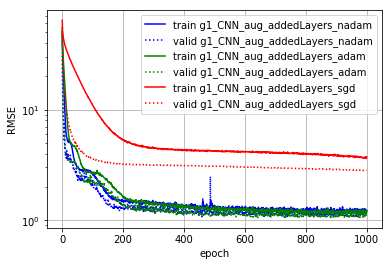

In [18]:
plot_loss([g1_CNN_aug_addedLayers_hist_nadam, g1_CNN_aug_addedLayers_hist_adam, g1_CNN_aug_addedLayers_hist_sgd],
           ['g1_CNN_aug_addedLayers_nadam','g1_CNN_aug_addedLayers_adam','g1_CNN_aug_addedLayers_sgd'])

<H3> Using VGG: </H3>

In [ ]:
# force grayscale into 3 channels
X1_train_3chan = np.tile(X1_train,(1,1,1,3))
X1_test_3chan = np.tile(X1_test,(1,1,1,3))
data_vgg=[X1_train_3chan, X1_test_3chan, Y1_train, Y1_test]

# new 3 channel data generator
datagen_vgg = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X1_train_3chan,Y1_train,whichlabels=list(labels1), batch_size=32)



In [ ]:
# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add the keypoints detection layer
predictions = Dense(30)(x)

# this is the model we will train
model_vgg = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

print(model_vgg.summary())
model_vgg_hist, model_vgg = fit_model(model_vgg, data_vgg,'g1_vgg', datagen_vgg, patience=1000)

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_vgg.layers[:249]:
    layer.trainable = False
for layer in model_vgg.layers[249:]:
    layer.trainable = True

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_vgg_hist2, model_vgg2 = fit_model(model_vgg, data_vgg,'g1_vgg2',datagen_vgg, patience=1000)

# train all layers!
for layer in model_vgg.layers:
    layer.trainable = True

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_vgg_hist3, model_vgg3 = fit_model(model_vgg, data_vgg,'g1_vgg3',datagen_vgg, patience=1000)

In [ ]:
# compare loss
model_vgg_hist_all = {}
model_vgg_hist_all['loss'] = (model_vgg_hist['loss'] + model_vgg_hist2['loss'] + model_vgg_hist3['loss'])
model_vgg_hist_all['val_loss'] = (model_vgg_hist['val_loss'] + model_vgg_hist2['val_loss'] + model_vgg_hist3['val_loss'])

plot_loss([g1_CNN_aug_addedLayers_hist, model_vgg_hist_all],
           ['g1_CNN_aug_addedLayers','g1_vgg'])


plot_loss([g1_CNN_aug_addedLayers_hist, model_vgg_hist, model_vgg_hist2, model_vgg_hist3],
           ['g1_CNN_aug_addedLayers','g1_vgg_1','g1_vgg_2','g1_vgg_3'])

### Using a model from the zoo
We try to train the InceptionV3 model to see if it does a better job. This model was chosen because it has good evaluation results, but has fewer parameters than some of the other competition-winning models.

#### Setup
In order to use InceptionV3, we need a 3 channel input. To fit this, we can just repeat the grayscale value for each of the 3 channels. We also have to change the data generator to create 3 channel images.

In [ ]:
# force grayscale into 3 channels
X1_train_3chan = np.tile(X1_train,(1,1,1,3))
X1_test_3chan = np.tile(X1_test,(1,1,1,3))
data1_inceptionV3=[X1_train_3chan, X1_test_3chan, Y1_train, Y1_test]

# new 3 channel data generator
datagen_inceptionV3 = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X1_train_3chan,Y1_train,whichlabels=list(labels1), batch_size=32)


#### Train the model
We train the model in 3 steps.
1. Create the base model and add a global average pooling layer, a dense layer, and an output layer. Then train the 3 added layers.
1. Train layers further up from the end (layer 250 through to the output layer).
1. Train all the layers.

In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add the keypoints detection layer
predictions = Dense(30)(x)

# this is the model we will train
model_inceptionV3 = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

print(model_inceptionV3.summary())
model_inceptionV3_hist, model_inceptionV3 = fit_model(model_inceptionV3, data1_inceptionV3,
                                                      'g1_zoo', datagen_inceptionV3,
                                                      patience=1000)

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_inceptionV3.layers[:249]:
    layer.trainable = False
for layer in model_inceptionV3.layers[249:]:
    layer.trainable = True

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_inceptionV3_hist2, model_inceptionV3 = fit_model(model_inceptionV3, data1_inceptionV3,
                                'g1_zoo2',datagen_inceptionV3,
                                patience=1000)


In [ ]:
# train all layers!
for layer in model_inceptionV3.layers:
    layer.trainable = True

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_inceptionV3_hist3, model_inceptionV3 = fit_model(model_inceptionV3, data1_inceptionV3,
                                'g1_zoo3',datagen_inceptionV3,
                                patience=1000)

In [ ]:
# compare loss
model_inceptionV3_hist_all = {}
model_inceptionV3_hist_all['loss'] = (model_inceptionV3_hist['loss'] +
                                      model_inceptionV3_hist2['loss'] +
                                      model_inceptionV3_hist3['loss']
                                      )
model_inceptionV3_hist_all['val_loss'] = (model_inceptionV3_hist['val_loss'] +
                                          model_inceptionV3_hist2['val_loss'] +
                                          model_inceptionV3_hist3['val_loss']
                                          )
plot_loss([g1_CNN_aug_addedLayers_hist, model_inceptionV3_hist, model_inceptionV3_hist2, model_inceptionV3_hist3],
           ['g1_CNN_aug_addedLayers','g1_inceptionV3_1','g1_inceptionV3_2','g1_inceptionV3_3'])
plot_loss([g1_CNN_aug_addedLayers_hist, model_vgg_hist, model_vgg_hist2, model_vgg_hist3],
           ['g1_CNN_aug_addedLayers','g1_vgg_1','g1_vgg_2','g1_vgg_3'])
plot_loss([g1_CNN_aug_addedLayers_hist, model_vgg_hist, model_vgg_hist3, model_inceptionV3_hist, model_inceptionV3_hist3],
           ['g1_CNN_aug_addedLayers','g1_vgg_1','g1_vgg_3','g1_inceptionV3_1','g1_inceptionV3_3'])
plot_loss([g1_CNN_aug_addedLayers_hist, model_vgg_hist, model_vgg_hist2, model_inceptionV3_hist, model_inceptionV3_hist3],
           ['g1_CNN_aug_addedLayers','g1_vgg_1','g1_vgg_2','g1_inceptionV3_1','g1_inceptionV3_3'])

It appears InceptionV3 loses out to our first data-augmented model. This is likely because we just don't have enough training examples to get enough variance into the Inception model that its generalization functionality works. It does appear the validation and training loss go hand in hand for the InceptionV3 model.